In [1]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import optimizers
from tensorflow.python.keras import losses
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Input, Dropout, Embedding, LSTM
from tensorflow.python.keras.optimizers import adam_v2
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras import regularizers

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow
import sys

print("Python: ", sys.version)
print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)

Python:  3.8.10 (default, May 19 2021, 13:12:57) [MSC v.1916 64 bit (AMD64)]
pandas:  1.2.4
numpy:  1.20.2
seaborn:  0.11.1
matplotlib:  3.3.4
sklearn:  0.24.2
Keras:  2.5.0
Tensorflow:  2.5.0


### Code to load MNIST images

In [2]:
from keras.datasets import mnist
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(
    x_train, (len(x_train), 28, 28,
              1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(
    x_test, (len(x_test), 28, 28,
             1))  # adapt this if using `channels_first` image data format

noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(
    loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(
    loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

print(x_train_noisy.shape)
print(x_test_noisy.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(10000,)


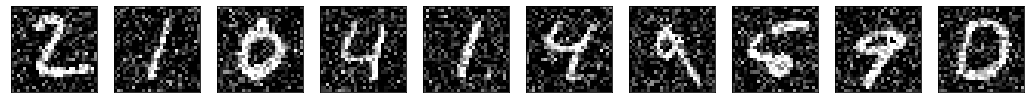

In [3]:
n = 11
plt.figure(figsize=(20, 2))
for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [4]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras import backend as K

input_img = Input(
    shape=(28, 28,
           1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [5]:
autoencoder.compile(optimizer=tf.keras.optimizers.RMSprop(),
                    loss='mean_squared_error',
                    metrics=['mae', 'accuracy'])

In [6]:
batch_size = 32
epochs = 20

history = autoencoder.fit(x_train_noisy,
                          x_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1,
                          shuffle=True,
                          validation_data=(x_test_noisy, x_test))

Epoch 1/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0380 - mae: 0.0906 - accuracy: 0.8003 - val_loss: 0.0259 - val_mae: 0.0674 - val_accuracy: 0.8024
Epoch 2/20
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0242 - mae: 0.0620 - accuracy: 0.8066 - val_loss: 0.0212 - val_mae: 0.0580 - val_accuracy: 0.8069
Epoch 3/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0210 - mae: 0.0560 - accuracy: 0.8085 - val_loss: 0.0196 - val_mae: 0.0533 - val_accuracy: 0.8099
Epoch 4/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0193 - mae: 0.0528 - accuracy: 0.8095 - val_loss: 0.0181 - val_mae: 0.0489 - val_accuracy: 0.8085
Epoch 5/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0182 - mae: 0.0507 - accuracy: 0.8102 - val_loss: 0.0179 - val_mae: 0.0514 - val_accuracy: 0.8099
Epoch 6/20
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0174 - mae: 0.0493 - accuracy:

In [7]:
score = autoencoder.evaluate(x_test, x_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 2s 5ms/step - loss: 0.0123 - mae: 0.0373 - accuracy: 0.8122
Test loss: 0.01227096188813448
Test accuracy: 0.03729074448347092


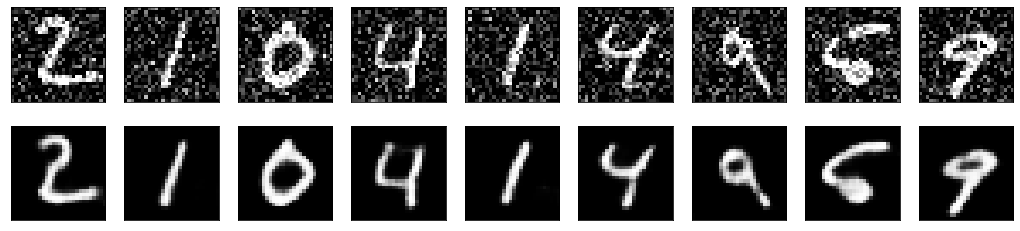

In [8]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

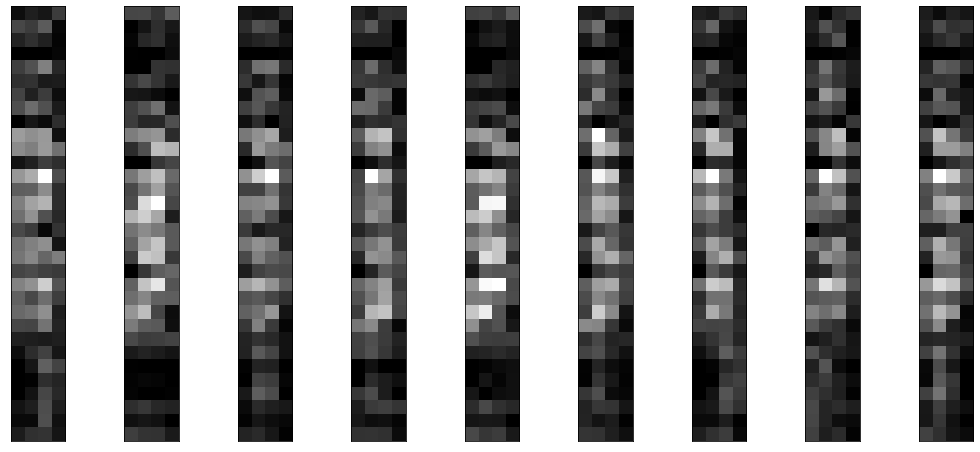

In [9]:
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test_noisy)
n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()